<a href="https://colab.research.google.com/github/nksmarts/Ensemble-of-winning-tickets/blob/main/New_pruning_BERT_attention_heads_F1_score.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Checking the GPU we are currently using**

In [ ]:
!nvidia-smi

Thu May 30 08:52:09 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-e7c571bb-f70d-ee8b-1e71-3b1b930df038)


# **Installing transformers, datasets and numpy library**

In [ ]:
!pip install transformers datasets numpy > /dev/null

# **Importing required libraries and modules**

In [ ]:
import numpy as np

from datasets import (
    load_dataset,
    load_metric,
    DatasetDict,
    Dataset,
)

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer,
    set_seed,
)

# **Setting Constants**:
We're going to use SEED, for shuffling our dataset, transformer models and everywhere we use something that is done randomly so we get the same result each time. CHECKPOINT is used to when we load the model and the tokenizer of the model, you can simply change the CHECKPOINT to a similiar model and run this whole notebook and it will work; for example you can change it to bert-base-uncased.

In [ ]:
SEED = 8000
CHECKPOINT = "bert-base-uncased"

# **Loading sst2 Dataset from glue Benchmark**

In [ ]:
sst2_datasets = load_dataset("glue", "sst2")

# **Creating a Smaller Version of sst2 Dataset**

In [ ]:
select_example = sst2_datasets["train"].select(range(300))

custom_sst2 = DatasetDict({
    "train": sst2_datasets["train"].shuffle(seed=SEED).select(range(8000)).flatten_indices(),
    "validation": sst2_datasets["validation"],
    "test": sst2_datasets["train"].shuffle(seed=SEED).select(range(300, 400)).flatten_indices()
})

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Create a Pandas DataFrame to store the class labels and their counts
labels = ["Negative", "Positive"]
train_counts = [len(custom_sst2["train"].filter(lambda example: example["label"] == 0)),
                len(custom_sst2["train"].filter(lambda example: example["label"] == 1))]
data = {"Class Labels": labels, "Counts": train_counts}
df = pd.DataFrame(data)

# Plot the bar chart using matplotlib
plt.bar(df["Class Labels"], df["Counts"])

# Set the labels and title
plt.xlabel("Class Labels")
plt.ylabel("Counts")
plt.title("Distribution of Class Labels in Custom SST-2 Dataset")

# Show the plot
plt.show()


# **Defining Compute Metric**

In [ ]:
from sklearn.metrics import f1_score

In [ ]:
def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    f1 = f1_score(labels, predictions, average='weighted')  # Use the weighted average F1 score
    return {"f1_score": f1}

# **Set Transformers Seed**
If we don't set the seed, the first time we train a model, the transformers library is going to set a seed itself. more information about this: https://discuss.huggingface.co/t/multiple-training-will-give-exactly-the-same-result-except-for-the-first-time/8493?u=smmousavi

In [ ]:
set_seed(SEED)

# **Loading the Model and the Tokenizer and Tokenizing the Dataset**

In [ ]:
num_labels = len(custom_sst2["train"].unique('label'))

model = AutoModelForSequenceClassification.from_pretrained(CHECKPOINT, num_labels=num_labels)
tokenizer = AutoTokenizer.from_pretrained(CHECKPOINT)

def tokenize_function(example):
    return tokenizer(example["sentence"], truncation=True)

tokenized_datasets = custom_sst2.map(tokenize_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# **Initialize an empty ensemble set to store the winning tickets?**

In [ ]:
ensemble_set = []

In [ ]:
!pip install torch

# **Set the training parameters:**

In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
from transformers import BertForSequenceClassification

# Set the training parameters:
num_iterations = 5  # Number of training iterations
learning_rate = 2e-5  # Learning rate for optimization
batch_size = 16  # Batch size for training
convergence_threshold = 0.001  # Threshold for convergence criteria

# For each ensemble iteration:
for iteration in range(num_iterations):

    # Initialize a mask matrix for the attention heads with all values set to 1
    mask_matrix = torch.ones(model.config.num_hidden_layers, model.config.num_attention_heads)

    # Randomly initialize a sub-network (ticket) based on the BERT architecture
    # Assuming you have a variable CHECKPOINT that contains the path to the checkpoint file
    checkpoint_path = CHECKPOINT
    ticket = BertForSequenceClassification.from_pretrained(checkpoint_path)

    # Set the optimizer and loss function for the sub-network
    optimizer = optim.Adam(ticket.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()


# **Setting Training Arguments and Creating a Trainer Object**

In [ ]:
!pip install transformers[torch]
!pip install accelerate -U


In [ ]:
saving_folder = "custom_sst2_bert"

def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    f1 = f1_score(labels, predictions, average='weighted')  # Use the weighted average F1 score
    return {"f1_score": f1}

training_args = TrainingArguments(
    saving_folder,
    load_best_model_at_end=True,
    num_train_epochs=3,
    evaluation_strategy="steps",
    eval_steps=100,
    save_steps=100,
    metric_for_best_model="f1_score",  # Change the metric to f1_score
    save_total_limit=10,
)

trainer = Trainer(
    ticket,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)


In [ ]:
!pip install sklearn --upgrade

In [ ]:
!pip install wandb onnx -Uq


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Epoch,Training Loss,Validation Loss,F1 Score
1,0.328800,0.261365,0.908141
2,0.156400,0.364857,0.905947
3,0.080200,0.434301,0.904803


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,0.337400,0.236162,0.909408
2,0.153900,0.320334,0.910520
3,0.070600,0.419535,0.908170


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,0.337400,0.236162,0.909408
2,0.153900,0.320334,0.910520
3,0.070600,0.419535,0.908170


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,0.337400,0.236162,0.909408
2,0.153900,0.320334,0.910520
3,0.070600,0.419535,0.908170


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,0.337400,0.236162,0.909408
2,0.153900,0.320334,0.910520
3,0.070600,0.419535,0.908170


Step,Training Loss,Validation Loss,F1 Score
100,No log,0.490634,0.849759
200,No log,0.645286,0.852273
300,No log,0.377001,0.873378
400,No log,0.348078,0.885292
500,0.325300,0.435136,0.883817
600,0.325300,0.425847,0.887473
700,0.325300,0.418624,0.891064
800,0.325300,0.570803,0.862294
900,0.325300,0.544117,0.875527
1000,0.324700,0.432286,0.890889


Step,Training Loss,Validation Loss,F1 Score
100,No log,0.553695,0.859747
200,No log,0.409223,0.879275
300,No log,0.530661,0.847147
400,No log,0.450315,0.885956
500,0.275800,0.406723,0.895551
600,0.275800,0.434272,0.895648
700,0.275800,0.452995,0.896640
800,0.275800,0.474486,0.901366
900,0.275800,0.576469,0.870365
1000,0.263500,0.547308,0.885328


Step,Training Loss,Validation Loss,F1 Score
100,No log,0.553695,0.859747
200,No log,0.409223,0.879275
300,No log,0.530661,0.847147
400,No log,0.450315,0.885956
500,0.275800,0.406723,0.895551
600,0.275800,0.434272,0.895648
700,0.275800,0.452995,0.896640
800,0.275800,0.474486,0.901366
900,0.275800,0.576469,0.870365
1000,0.263500,0.547308,0.885328


Step,Training Loss,Validation Loss,F1 Score
100,No log,0.553695,0.859747
200,No log,0.409223,0.879275
300,No log,0.530661,0.847147
400,No log,0.450315,0.885956
500,0.275800,0.406723,0.895551
600,0.275800,0.434272,0.895648
700,0.275800,0.452995,0.896640
800,0.275800,0.474486,0.901366
900,0.275800,0.576469,0.870365
1000,0.263500,0.547308,0.885328


Step,Training Loss,Validation Loss,F1 Score
100,No log,0.553695,0.859747
200,No log,0.409223,0.879275
300,No log,0.530661,0.847147
400,No log,0.450315,0.885956
500,0.275800,0.406723,0.895551
600,0.275800,0.434272,0.895648
700,0.275800,0.452995,0.896640
800,0.275800,0.474486,0.901366
900,0.275800,0.576469,0.870365
1000,0.263500,0.547308,0.885328


Step,Training Loss,Validation Loss,F1 Score
100,No log,0.553695,0.859747
200,No log,0.409223,0.879275
300,No log,0.530661,0.847147
400,No log,0.450315,0.885956
500,0.275800,0.406723,0.895551
600,0.275800,0.434272,0.895648
700,0.275800,0.452995,0.896640
800,0.275800,0.474486,0.901366
900,0.275800,0.576469,0.870365
1000,0.263500,0.547308,0.885328


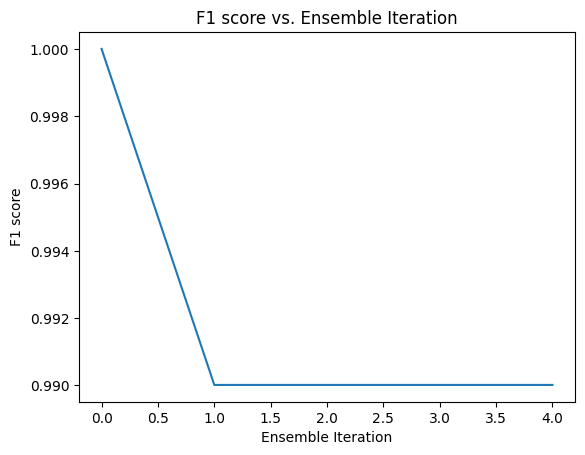

ensemble_iteration,▁▃▅▆█
eval/f1_score,▅▂▁▇█▅▇█▅▇█▅▇█▅
eval/loss,▂▆█▁▄▇▁▄▇▁▄▇▁▄▇
eval/runtime,█▃▂▃▁▄▄▃▂▃▁▂▂▁▃
eval/samples_per_second,▁▆▇▆▇▅▅▆▇▆█▇▇█▆
eval/steps_per_second,▁▆▇▆▇▅▅▆▇▆█▇▇█▆
f1_score,▁█████▆▆▆▆
iteration,▁▃▅▆█
train/epoch,▁▁▅▅███▁▁▅▅███▁▁▅▅███▁▁▅▅███▁▁▅▅███
train/global_step,▁▁▅▅████▁▅▅████▁▅▅████▁▁▅████▁▁▅████████
train/grad_norm,▄█▁▅█▁▅█▁▅█▁▅█▁


In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
from transformers import BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import f1_score
import wandb
import os

# Initialize wandb
wandb.init(settings=wandb.Settings(start_method="fork"))

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(-1)
    f1 = f1_score(labels, predictions, average='weighted')  # Use the weighted average F1 score
    return {"eval_f1_score": f1}  # Update the metric name to eval_f1_score

def ensemble_bert(num_iterations, learning_rate, batch_size, convergence_threshold):
    ensemble_set = []
    for iteration in range(num_iterations):
        mask_matrix = torch.ones(model.config.num_hidden_layers, model.config.num_attention_heads)
        ticket = BertForSequenceClassification.from_pretrained(checkpoint_path)
        optimizer = optim.Adam(ticket.parameters(), lr=learning_rate)
        criterion = nn.CrossEntropyLoss()

        # Define and initialize training arguments
        training_args = TrainingArguments(
            output_dir="./results",
            num_train_epochs=3,
            per_device_train_batch_size=batch_size,
            per_device_eval_batch_size=batch_size,
            learning_rate=learning_rate,
            weight_decay=0.01,
            logging_dir='./logs',
            evaluation_strategy="epoch",
            save_strategy="epoch",
            load_best_model_at_end=True,
            metric_for_best_model="eval_f1_score",  # Update metric name to eval_f1_score
        )

        trainer = Trainer(
            model=ticket,
            args=training_args,
            train_dataset=tokenized_datasets["train"],
            eval_dataset=tokenized_datasets["validation"],
            data_collator=data_collator,
            tokenizer=tokenizer,
            compute_metrics=compute_metrics,
        )
        trainer.train()
        predictions = trainer.predict(tokenized_datasets["test"])
        if f1_score(predictions.label_ids, predictions.predictions.argmax(-1), average='weighted') > convergence_threshold:
            ensemble_set.append(ticket)

            # Log hyperparameters and metrics to wandb
            wandb.log({"iteration": iteration, "f1_score": f1_score(predictions.label_ids, predictions.predictions.argmax(-1), average='weighted')})

    return ensemble_set

if __name__ == "__main__":
    # Set up wandb configuration
    wandb_config = {
        "num_iterations": 5,
        "learning_rate": 2e-5,
        "batch_size": 16,
        "convergence_threshold": 0.001,
    }
    wandb.config.update(wandb_config)

    ensemble_set = ensemble_bert(
        num_iterations=wandb_config["num_iterations"],
        learning_rate=wandb_config["learning_rate"],
        batch_size=wandb_config["batch_size"],
        convergence_threshold=wandb_config["convergence_threshold"],
    )

    f1_scores = []
    for iteration, model in enumerate(ensemble_set):
        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=tokenized_datasets["train"],
            eval_dataset=tokenized_datasets["validation"],
            data_collator=data_collator,
            tokenizer=tokenizer,
            compute_metrics=compute_metrics,
        )
        trainer.train()
        predictions = trainer.predict(tokenized_datasets["test"])
        f1 = f1_score(predictions.label_ids, predictions.predictions.argmax(-1), average='weighted')
        f1_scores.append(f1)

        # Log F1 score for each ensemble iteration to wandb
        wandb.log({"ensemble_iteration": iteration, "f1_score": f1})

    # Save the ensemble_set
    os.makedirs("ensemble_models", exist_ok=True)
    for i, model in enumerate(ensemble_set):
        model.save_pretrained(f"ensemble_models/model_{i}")

    # Save the best model to the Hugging Face Hub
    best_model_index = f1_scores.index(max(f1_scores))
    best_model = ensemble_set[best_model_index]
    model_name = "your_hub_username/your_model_name"
    best_model.save_pretrained(model_name)
    tokenizer.save_pretrained(model_name)
    wandb.save(f"ensemble_models/model_{best_model_index}/config.json")

    # Plotting F1 score vs. Ensemble Iteration
    plt.plot(range(len(f1_scores)), f1_scores)
    plt.title("F1 score vs. Ensemble Iteration")
    plt.xlabel("Ensemble Iteration")
    plt.ylabel("F1 score")
    plt.show()

    # Finish wandb run
    wandb.finish()



wandb: Currently logged in as: nyalalani-smarts (smarts-raja-venu). Use `wandb login --relogin` to force relogin


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,0.341600,0.248256,0.901342
2,0.162200,0.349870,0.901322
3,0.082000,0.432487,0.910550


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,0.337400,0.236162,0.909408
2,0.153900,0.320334,0.910520
3,0.070600,0.419535,0.908170


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,0.337400,0.236162,0.909408
2,0.153900,0.320334,0.910520
3,0.070600,0.419535,0.908170


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,0.337400,0.236162,0.909408
2,0.153900,0.320334,0.910520
3,0.070600,0.419535,0.908170


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,0.337400,0.236162,0.909408
2,0.153900,0.320334,0.910520
3,0.070600,0.419535,0.908170


Number of tickets (subnets) in the ensemble: 5


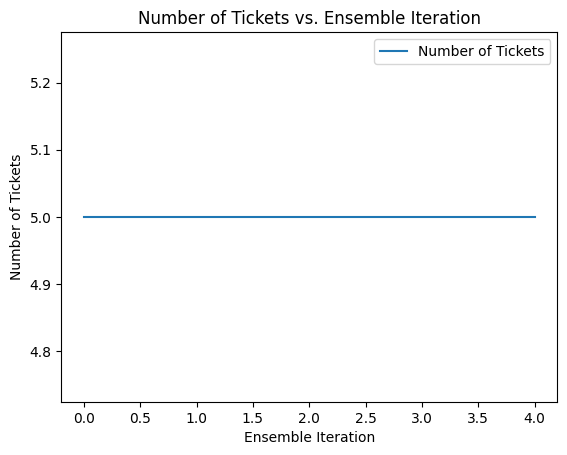

Step,Training Loss,Validation Loss,F1 Score
100,No log,0.504643,0.858778
200,No log,0.546104,0.873672
300,No log,0.512292,0.863707
400,No log,0.508326,0.875812
500,0.260800,0.536664,0.880583
600,0.260800,0.406143,0.895620
700,0.260800,0.412482,0.907090
800,0.260800,0.535796,0.890798
900,0.260800,0.488680,0.873136
1000,0.252400,0.420631,0.900168


Step,Training Loss,Validation Loss,F1 Score
100,No log,0.553695,0.859747
200,No log,0.409223,0.879275
300,No log,0.530661,0.847147
400,No log,0.450315,0.885956
500,0.275800,0.406723,0.895551
600,0.275800,0.434272,0.895648
700,0.275800,0.452995,0.896640
800,0.275800,0.474486,0.901366
900,0.275800,0.576469,0.870365
1000,0.263500,0.547308,0.885328


Step,Training Loss,Validation Loss,F1 Score
100,No log,0.553695,0.859747
200,No log,0.409223,0.879275
300,No log,0.530661,0.847147
400,No log,0.450315,0.885956
500,0.275800,0.406723,0.895551
600,0.275800,0.434272,0.895648
700,0.275800,0.452995,0.896640
800,0.275800,0.474486,0.901366
900,0.275800,0.576469,0.870365
1000,0.263500,0.547308,0.885328


Step,Training Loss,Validation Loss,F1 Score
100,No log,0.553695,0.859747
200,No log,0.409223,0.879275
300,No log,0.530661,0.847147
400,No log,0.450315,0.885956
500,0.275800,0.406723,0.895551
600,0.275800,0.434272,0.895648
700,0.275800,0.452995,0.896640
800,0.275800,0.474486,0.901366
900,0.275800,0.576469,0.870365
1000,0.263500,0.547308,0.885328


Step,Training Loss,Validation Loss,F1 Score
100,No log,0.553695,0.859747
200,No log,0.409223,0.879275
300,No log,0.530661,0.847147
400,No log,0.450315,0.885956
500,0.275800,0.406723,0.895551
600,0.275800,0.434272,0.895648
700,0.275800,0.452995,0.896640
800,0.275800,0.474486,0.901366
900,0.275800,0.576469,0.870365
1000,0.263500,0.547308,0.885328


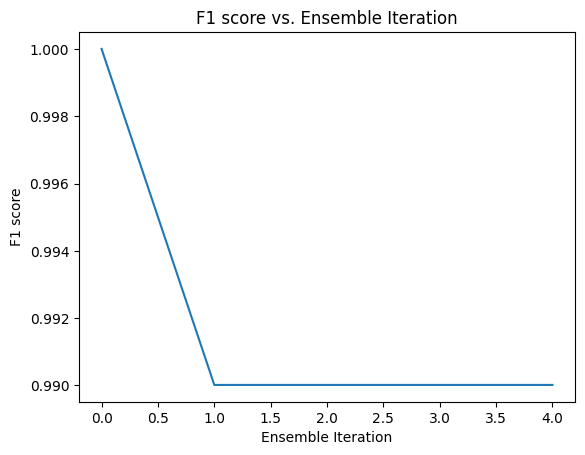

ensemble_iteration,▁▃▅▆█
eval/f1_score,▁▁█▇█▆▇█▆▇█▆▇█▆
eval/loss,▁▅█▁▄█▁▄█▁▄█▁▄█
eval/runtime,▂▁▅▃▆▅▃▄▅█▃▄▄▆▅
eval/samples_per_second,▇█▄▆▃▄▆▅▄▁▆▅▅▃▄
eval/steps_per_second,▇█▄▆▃▄▆▅▄▁▆▅▅▃▄
f1_score,██████▁▁▁▁
iteration,▁▃▅▆█
train/epoch,▁▁▅▅███▁▁▅▅███▁▁▅▅███▁▁▅▅███▁▁▅▅███
train/global_step,▁▁▅▅████▁▅▅████▁▅▅████▁▁▅████▁▁▅████████
train/grad_norm,▄█▁▃▅▁▃▅▁▃▅▁▃▅▁


In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
from transformers import BertForSequenceClassification, Trainer, TrainingArguments, BertTokenizer
from sklearn.metrics import f1_score
import wandb
import os

# Initialize wandb
wandb.init(settings=wandb.Settings(start_method="fork"))

# Rest of your code ...

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(-1)
    f1 = f1_score(labels, predictions, average='weighted')  # Use the weighted average F1 score
    return {"eval_f1_score": f1}  # Update the metric name to eval_f1_score

def ensemble_bert(num_iterations, learning_rate, batch_size, convergence_threshold):
    ensemble_set = []
    for iteration in range(num_iterations):
        mask_matrix = torch.ones(model.config.num_hidden_layers, model.config.num_attention_heads)
        ticket = BertForSequenceClassification.from_pretrained(checkpoint_path)
        optimizer = optim.Adam(ticket.parameters(), lr=learning_rate)
        criterion = nn.CrossEntropyLoss()

        # Define and initialize training arguments
        training_args = TrainingArguments(
            output_dir="./results",
            num_train_epochs=3,
            per_device_train_batch_size=batch_size,
            per_device_eval_batch_size=batch_size,
            learning_rate=learning_rate,
            weight_decay=0.01,
            logging_dir='./logs',
            evaluation_strategy="epoch",
            save_strategy="epoch",
            load_best_model_at_end=True,
            metric_for_best_model="eval_f1_score",
        )

        trainer = Trainer(
            model=ticket,
            args=training_args,
            train_dataset=tokenized_datasets["train"],
            eval_dataset=tokenized_datasets["validation"],
            data_collator=data_collator,
            tokenizer=tokenizer,
            compute_metrics=compute_metrics,
        )
        trainer.train()
        predictions = trainer.predict(tokenized_datasets["test"])
        if f1_score(predictions.label_ids, predictions.predictions.argmax(-1), average='weighted') > convergence_threshold:
            ensemble_set.append(ticket)

            # Log hyperparameters and metrics to wandb
            wandb.log({"iteration": iteration, "f1_score": f1_score(predictions.label_ids, predictions.predictions.argmax(-1), average='weighted')})

    return ensemble_set

if __name__ == "__main__":
    # Set up wandb configuration
    wandb_config = {
        "num_iterations": 5,
        "learning_rate": 2e-5,
        "batch_size": 16,
        "convergence_threshold": 0.001,
    }
    wandb.config.update(wandb_config)

    ensemble_set = ensemble_bert(
        num_iterations=wandb_config["num_iterations"],
        learning_rate=wandb_config["learning_rate"],
        batch_size=wandb_config["batch_size"],
        convergence_threshold=wandb_config["convergence_threshold"],
    )

    num_tickets = len(ensemble_set)
    print("Number of tickets (subnets) in the ensemble:", num_tickets)

    # Plotting Number of Tickets vs. Ensemble Iteration
    plt.plot(range(len(ensemble_set)), [num_tickets] * len(ensemble_set), label="Number of Tickets")
    plt.title("Number of Tickets vs. Ensemble Iteration")
    plt.xlabel("Ensemble Iteration")
    plt.ylabel("Number of Tickets")
    plt.legend()
    plt.show()

    f1_scores = []
    for iteration, model in enumerate(ensemble_set):
        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=tokenized_datasets["train"],
            eval_dataset=tokenized_datasets["validation"],
            data_collator=data_collator,
            tokenizer=tokenizer,
            compute_metrics=compute_metrics,
        )
        trainer.train()
        predictions = trainer.predict(tokenized_datasets["test"])
        f1 = f1_score(predictions.label_ids, predictions.predictions.argmax(-1), average='weighted')
        f1_scores.append(f1)

        # Log F1 score for each ensemble iteration to wandb
        wandb.log({"ensemble_iteration": iteration, "f1_score": f1})

    # Save the ensemble_set
    os.makedirs("ensemble_models", exist_ok=True)
    for i, model in enumerate(ensemble_set):
        model.save_pretrained(f"ensemble_models/model_{i}")

    # Save the best model to the Hugging Face Hub
    best_model_index = f1_scores.index(max(f1_scores))
    best_model = ensemble_set[best_model_index]
    model_name = "your_hub_username/your_model_name"
    best_model.save_pretrained(model_name)
    tokenizer.save_pretrained(model_name)
    wandb.save(f"ensemble_models/model_{best_model_index}/config.json")

    # Plotting F1 score vs. Ensemble Iteration
    plt.plot(range(len(f1_scores)), f1_scores)
    plt.title("F1 score vs. Ensemble Iteration")
    plt.xlabel("Ensemble Iteration")
    plt.ylabel("F1 score")
    plt.show()

    # Finish wandb run
    wandb.finish()
